<a href="https://colab.research.google.com/github/INA-95/spotify_api/blob/main/Spotify_api_231024.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [82]:
# library

import requests
import base64
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.cluster import KMeans
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Function

# authorization

def get_access_token(client_id:str, client_secret:str) -> str:
    auth_url = 'https://accounts.spotify.com/api/token'
    auth_header = {
        'Authorization': f'Basic {base64.b64encode((client_id + ":" + client_secret).encode()).decode()}'
    }

    auth_data = {
        'grant_type': 'client_credentials',
        'client_id' : client_id,
        'client_secret' : client_secret
    }

    auth_response = requests.post(auth_url, data = auth_data, headers = auth_header)
    auth_response_data = auth_response.json()
    access_token = auth_response_data['access_token']
    return access_token


# get your playlists

def get_playlists(access_token:str, user_name:str) -> dict:
    headers = {"Authorization" : f"Bearer {access_token}"}
    res = requests.get(
        f"https://api.spotify.com/v1/users/{user_name}/playlists",
        headers = headers
    )

    playlist_array = res.json()['items']
    playlist_dict = {playlist['id']:playlist['name'] for playlist in playlist_array}

    return playlist_dict


# get your tracks (playlist > track)

def get_playlist_tracks(access_token:str, playlist_dict:list[str], user_name:str) -> dict:
    headers = {"Authorization": f"Bearer {access_token}"}
    offset = 0

    tracks = []
    playlist_ids = [playlist_id for playlist_id in playlist_dict.keys()]

    for playlist_id in playlist_ids:

        res = requests.get(
            f"https://api.spotify.com/v1/users/{user_name}/playlists/{playlist_id}/tracks?offset={offset}",
            headers=headers
        )
        track = res.json()
        tracks.append(track)

    return tracks

# get artist, title, track_id

def get_track_info(tracks:list[dict[str]]) -> pd.DataFrame:

    artists = []
    titles = []
    track_ids = []

    for track in tracks:
        for val in track['items']:
            track_info = val.get('track')

            artist = track_info.get('artists')
            artist = artist[0]['name']

            title = track_info.get('name')
            track_id = val.get('track')['uri'].split(':')[-1]

            artists.append(artist)
            titles.append(title)
            track_ids.append(track_id)

        df = pd.DataFrame(list(zip(titles, artists, track_ids)),
                        columns = ['title', 'artist', 'track_id'])

    return df


# get your tracks audio feature

def tracks_audio_features(access_token:str, track_ids:list[str]) -> pd.DataFrame:

    feature_lst = []

    for track_id in track_ids:
        headers = {"Authorization" : f"Bearer {access_token}"}
        res = requests.get(
            f"https://api.spotify.com/v1/audio-features/{track_id}",
            headers = headers
        )
        feature = res.json()

        feature_lst.append(feature)
        df = pd.DataFrame.from_dict(feature_lst)

    return df

In [4]:
# Implementation

client_id = ""
client_secret = ""
user_name = ""

access_token = get_access_token(client_id, client_secret)
playlist_dict = get_playlists(access_token, user_name)
tracks = get_playlist_tracks(access_token, playlist_dict, user_name)

In [5]:
df1 = get_track_info(tracks)
df1.drop_duplicates(inplace = True)

track_ids = [track_id for track_id in df1['track_id']]
df2 = tracks_audio_features(access_token, track_ids)

final = df1.merge(df2, how = 'inner', left_on = 'track_id', right_on = 'id')
final.head()

,title,artist,track_id,danceability,energy,key,loudness,mode,speechiness,acousticness,...,liveness,valence,tempo,type,id,uri,track_href,analysis_url,duration_ms,time_signature
0,PLAY,LUCY,0ddSLVdbpKFO1FtIYpYnw9,0.424,0.663,5,-4.133,1,0.0391,0.63400,...,0.1120,0.196,186.093,audio_features,0ddSLVdbpKFO1FtIYpYnw9,spotify:track:0ddSLVdbpKFO1FtIYpYnw9,https://api.spotify.com/v1/tracks/0ddSLVdbpKFO...,https://api.spotify.com/v1/audio-analysis/0ddS...,226880,4
1,Replay,SHINee,1rp986nzkyAX1wFpxzbwlC,0.716,0.779,1,-2.203,1,0.0805,0.17800,...,0.1670,0.590,99.977,audio_features,1rp986nzkyAX1wFpxzbwlC,spotify:track:1rp986nzkyAX1wFpxzbwlC,https://api.spotify.com/v1/tracks/1rp986nzkyAX...,https://api.spotify.com/v1/audio-analysis/1rp9...,213827,4
2,What's Happening?,B1A4,0pssH13oORltxWa5MIvEuI,0.623,0.745,9,-3.536,1,0.0562,0.00461,...,0.1590,0.698,135.013,audio_features,0pssH13oORltxWa5MIvEuI,spotify:track:0pssH13oORltxWa5MIvEuI,https://api.spotify.com/v1/tracks/0pssH13oORlt...,https://api.spotify.com/v1/audio-analysis/0pss...,200346,4
3,Trouble Maker,Trouble Maker,0RP3Qjp1QhIjhtG7gYoBqn,0.838,0.805,10,-2.723,0,0.0541,0.08260,...,0.0778,0.952,115.026,audio_features,0RP3Qjp1QhIjhtG7gYoBqn,spotify:track:0RP3Qjp1QhIjhtG7gYoBqn,https://api.spotify.com/v1/tracks/0RP3Qjp1QhIj...,https://api.spotify.com/v1/audio-analysis/0RP3...,219638,4
4,12:30,Beast,0uvl4TuFhdWZshHX9Hd6kI,0.637,0.792,1,-2.932,1,0.0330,0.34600,...,0.0743,0.536,99.909,audio_features,0uvl4TuFhdWZshHX9Hd6kI,spotify:track:0uvl4TuFhdWZshHX9Hd6kI,https://api.spotify.com/v1/tracks/0uvl4TuFhdWZ...,https://api.spotify.com/v1/audio-analysis/0uvl...,233848,3


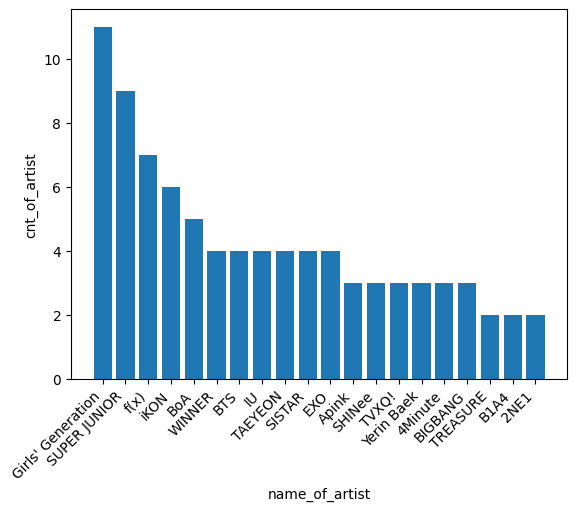

In [7]:
# favorite artist

fav_artist = final['artist'].value_counts().reset_index().head(20)

fig, ax = plt.subplots()
x = fav_artist['index'].tolist()
y = fav_artist['artist'].tolist()
ax.bar(x, y)
ax.set_ylabel('cnt_of_artist')
ax.set_xlabel('name_of_artist')
plt.xticks(rotation = 45, ha = 'right')

plt.show()

In [8]:
# Audio feature analysis

audio_feature_df = final[['title', 'artist', 'danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence']]
audio_feature_df.head()

,title,artist,danceability,energy,loudness,speechiness,acousticness,instrumentalness,liveness,valence
0,PLAY,LUCY,0.424,0.663,-4.133,0.0391,0.63400,0.000095,0.1120,0.196
1,Replay,SHINee,0.716,0.779,-2.203,0.0805,0.17800,0.000001,0.1670,0.590
2,What's Happening?,B1A4,0.623,0.745,-3.536,0.0562,0.00461,0.000000,0.1590,0.698
3,Trouble Maker,Trouble Maker,0.838,0.805,-2.723,0.0541,0.08260,0.000004,0.0778,0.952
4,12:30,Beast,0.637,0.792,-2.932,0.0330,0.34600,0.000000,0.0743,0.536


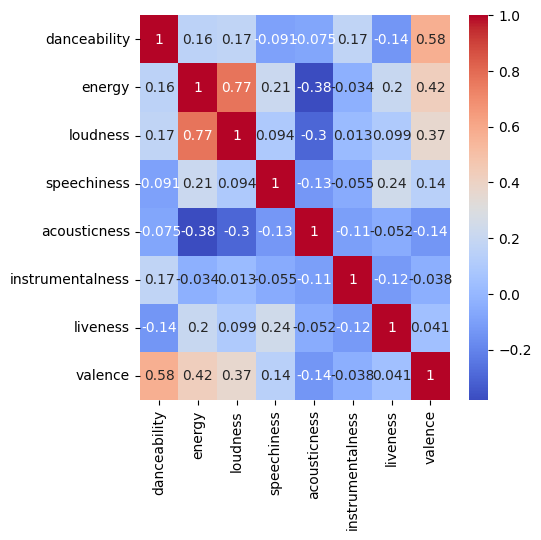

In [13]:
# Correlation between audio features

target_vals = audio_feature_df[['danceability', 'energy', 'loudness', 'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence']]
f, ax = plt.subplots(figsize = (5, 5))
ax = sns.heatmap(target_vals.corr(), annot = True, cmap = 'coolwarm')

In [78]:
# Top_N song by each of audio feature

def top_n_song_by_audio_feature(df:pd.DataFrame, feature:str, n:int):
    df = df[['title', 'artist', feature]].sort_values(by = feature, ascending = True).head(n)

    titles = [title for title in df['title']]
    features = [feature for feature in df[feature]]
    y = np.arange(n)

    plt.barh(y, features)
    plt.yticks(y, titles)

    plt.show()

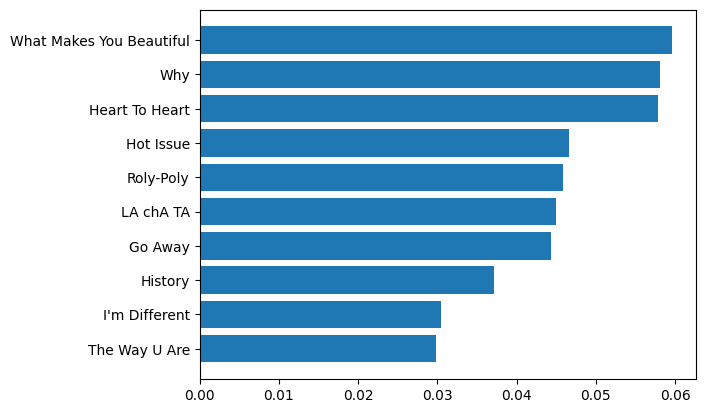

In [79]:
top_n_song_by_audio_feature(audio_feature_df, 'liveness', 10)

In [83]:
# Audio feature Clustering

k_rng = range(1, 10)
sse = []

for k in k_rng:
    km = KMeans(n_clusters=k)
    km.fit(target_vals)
    sse.append(km.inertia_)

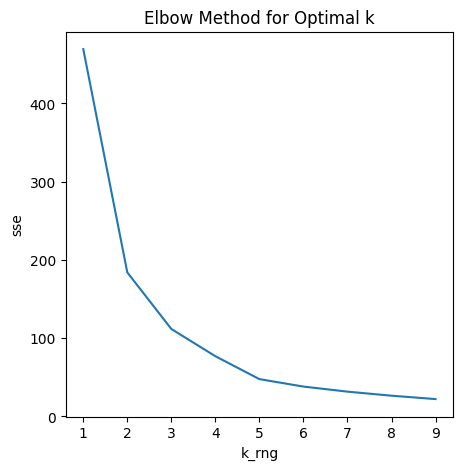

In [85]:
plt.figure(figsize = (5, 5))
plt.plot(k_rng, sse)
plt.xlabel('k_rng')
plt.ylabel('sse')
plt.title('Elbow Method for Optimal k')
plt.show()